In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.c_country import C_Country
from utils.graph_generator import get_path

from utils.dotdict import dotdict
from scripts.launch_measure import init_graph, get_centrum

from src.params import GIRG_args1,GIRG_args2,GIRG_args3,GIRG_args4, get_moving


import seaborn as sn
import matplotlib.pyplot as plt
sn.set_theme(style="whitegrid")

import pickle

In [2]:
args = {
    "--p_moving": 0.015, 
    "--p_worker": 1.0, 
    "--beta": 0.5,
    "--beta_super":0.0, 
    "--seed": 0,
    "--sigma": 1.0, 
    "--gamma": 0.2,
    "--max_sim": 500,
    "inf_agent_num":1000,
}

In [3]:
import pandas as pd
    
def save_to_file(betas, agg1, agg2, seed, filename):
    df = pd.DataFrame()
    for beta,sims in zip(betas,agg1):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=True
        df = df.append(row, ignore_index=True)
    for beta,sims in zip(betas,agg2):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=False
        df=df.append(row, ignore_index=True)
    df.to_csv(filename)

In [4]:
for seed in range(16, 25):
    #for config in [False]:
    for config in [True, False]:
        for GIRG_args in [GIRG_args1 ,GIRG_args2, GIRG_args3, GIRG_args4]:
            GIRG_args["config_model"]=config
            GIRG_args["random_seed"]=seed
            graph = init_graph(GIRG_args)
            hun = C_Country(graph)

            pm = get_moving(graph, procent = 0.001)
            
            print(pm)

0.24557709221419813
0.10593801705602074
0.05422933778013904
0.06468000640332063
0.24557709221419813
0.10593801705602074
0.05422933778013904
0.06468000640332063
0.04474400315445223
0.02434600090080203
0.01713695479411131
0.019509333908858686
0.04474400315445223
0.02434600090080203
0.01713695479411131
0.019509333908858686
0.04164333604015017
0.020082388871352084
0.013530000277365006
0.01576000037824001
0.04164333604015017
0.020082388871352084
0.013530000277365006
0.01576000037824001
0.04012500250781266
0.01733100045927151
0.011561666868995839
0.013448000275684007
0.04012500250781266
0.01733100045927151
0.011561666868995839
0.013448000275684007
0.04971667056942531
0.023773667534405532
0.016104667061231013
0.017766000479682006
0.04971667056942531
0.023773667534405532
0.016104667061231013
0.017766000479682006
0.05782800529126246
0.02889333460464006
0.019489667241611854
0.02094933400371202
0.05782800529126246
0.02889333460464006
0.019489667241611854
0.02094933400371202
0.036890002194955133
0

# GIRG

In [4]:
betas = np.concatenate(
    (np.linspace(args["--gamma"], 1.3*args["--gamma"], 12),
     np.linspace(1.3*args["--gamma"], 2.0*args["--gamma"], 15)[1:])
)

In [5]:
betas

array([0.2       , 0.20545455, 0.21090909, 0.21636364, 0.22181818,
       0.22727273, 0.23272727, 0.23818182, 0.24363636, 0.24909091,
       0.25454545, 0.26      , 0.27      , 0.28      , 0.29      ,
       0.3       , 0.31      , 0.32      , 0.33      , 0.34      ,
       0.35      , 0.36      , 0.37      , 0.38      , 0.39      ,
       0.4       ])

In [6]:
args["procnum"] = 30
args["simnum"] = 35

inf_city = 30

In [ ]:
%time
for seed in range(16, 25):
    #for config in [False]:
    for config in [True, False]:
        for GIRG_args in [GIRG_args1 ,GIRG_args2, GIRG_args3, GIRG_args4]:
            GIRG_args["config_model"]=config
            GIRG_args["random_seed"]=seed
            graph = init_graph(GIRG_args)
            hun = C_Country(graph)

            pm = get_moving(graph, procent = 0.001)
            args["--p_moving"]=pm

            centrum = get_centrum(graph, "k-core", inf_city)
            agg1 = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")
            periphery = [n for n in graph.nodes() if n not in centrum] 
            agg2 = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")

            graph_name = "Config" if config else "GIRG"
            tau = GIRG_args["tau"]
            alpha = GIRG_args["alpha"]
            filename = "girgs_final/{}_tau:{}_alpha:{}_seed:{}.csv".format(
                graph_name, tau, alpha,seed)
            
            save_to_file(betas, agg1, agg2, seed, filename)

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 18.1 µs
 380/910

In [14]:
def save_file(df, file):
    df_cen = df[df["cen"]==True].drop(['beta', 'cen'], axis=1).mean(1)
    df_per = df[df["cen"]==False].drop(['beta', 'cen'], axis=1).mean(1)
    betas = df[df["cen"]==True]["beta"]

    df_agg = pd.DataFrame()
    df_agg["betas"]=df[df["cen"]==True]["beta"]
    df_agg["mean1"]=df_cen
    df_agg["std1"]=df[df["cen"]==True].drop(['beta', 'cen'], axis=1).std(1)
    df_agg["mean2"]=np.array(df_per)
    df_agg["std2"]=np.array(df[df["cen"]==False].drop(['beta', 'cen'], axis=1).std(1))
    df_agg["ratio"]=df_agg["mean1"]/df_agg["mean2"]
    A = 1.645/np.sqrt(df.drop(['beta', 'cen'], axis=1).shape[1])
    df_agg["conf1_lower"] = df_agg["mean1"]-df_agg["std1"]*A
    df_agg["conf1_upper"] = df_agg["mean1"]+df_agg["std1"]*A
    df_agg["conf2_lower"] = df_agg["mean2"]-df_agg["std2"]*A
    df_agg["conf2_upper"] = df_agg["mean2"]+df_agg["std2"]*A
    df_agg["lower"] = df_agg["conf1_lower"]/df_agg["conf2_upper"]
    df_agg["upper"] = df_agg["conf1_upper"]/df_agg["conf2_lower"]

    df_agg.to_csv("girgs_final/aggregation/"+file+"_agg.csv")
    
    return df_agg

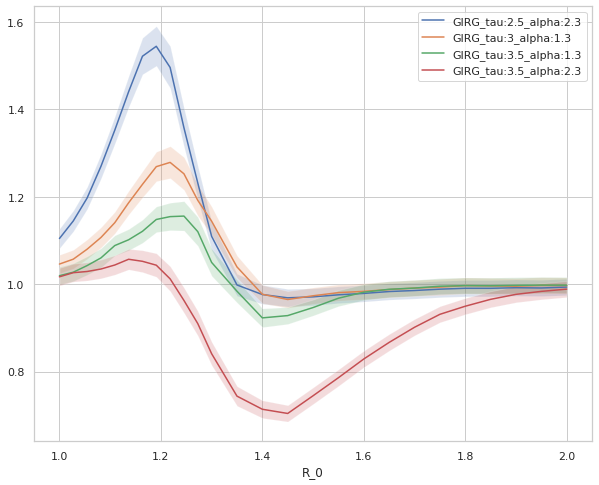

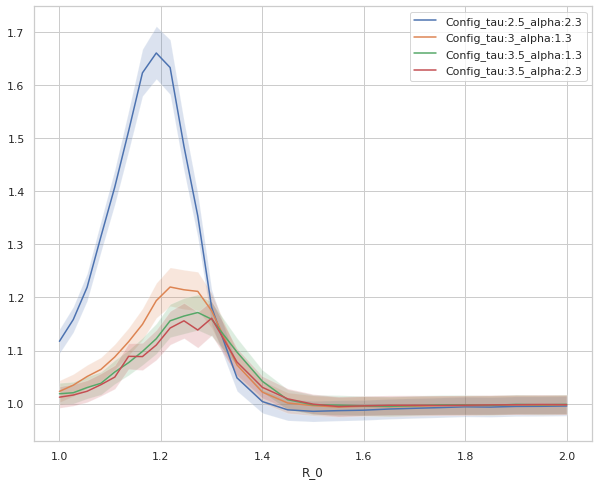

In [15]:
for files in [["GIRG_tau:2.5_alpha:2.3","GIRG_tau:3_alpha:1.3",
                 "GIRG_tau:3.5_alpha:1.3","GIRG_tau:3.5_alpha:2.3"],
              ["Config_tau:2.5_alpha:2.3","Config_tau:3_alpha:1.3",
                  "Config_tau:3.5_alpha:1.3","Config_tau:3.5_alpha:2.3"]]:
    plt.figure(figsize=(10,8))
    for file in files:
        df = pd.read_csv("girgs_final/{}_seed:{}.csv".format(file, 0))
        for seed in range(0,25):
            df_temp = pd.read_csv("girgs_final/{}_seed:{}.csv".format(file, seed))
            df = pd.merge(df,df_temp, how='inner', left_on=['beta','cen'], right_on=['beta','cen'])

        df["mean"] = df.drop(['beta', 'cen'], axis=1).mean(1)
        df["std"] = df.drop(['beta', 'cen'], axis=1).std(1)

        df.to_csv("girgs_final/aggregation/"+file+"_all.csv")
        df_agg = save_file(df, file)

        plt.plot(betas/args["--gamma"], df_agg["ratio"].values, label=file)
        plt.fill_between(betas/args["--gamma"], df_agg["lower"].values, df_agg["upper"].values,
                         alpha=0.2)
    plt.xlabel("R_0")
    plt.legend()
    plt.show()

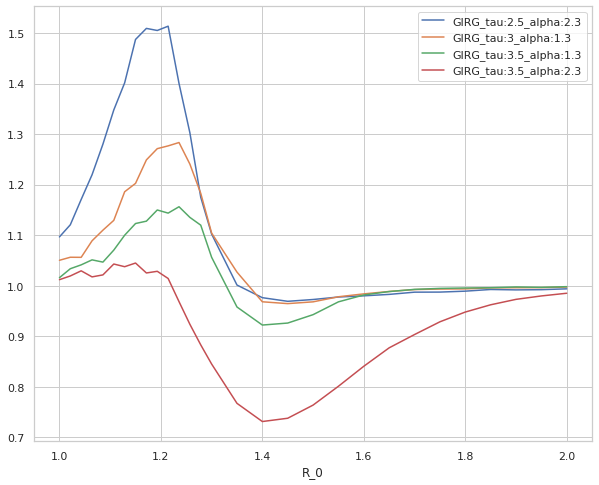

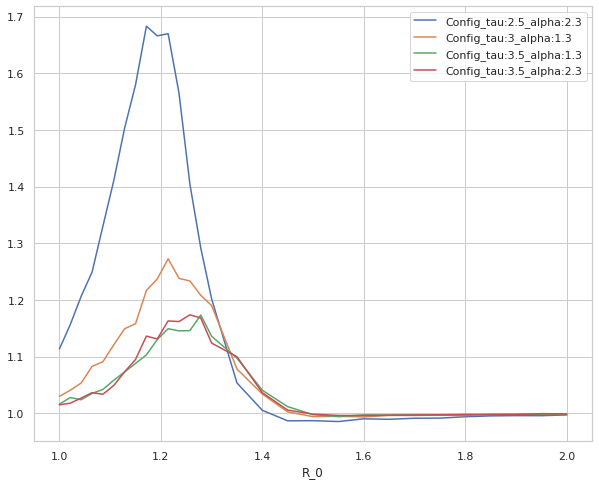

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

for files in [["GIRG_tau:2.5_alpha:2.3","GIRG_tau:3_alpha:1.3",
                 "GIRG_tau:3.5_alpha:1.3","GIRG_tau:3.5_alpha:2.3"],
              ["Config_tau:2.5_alpha:2.3","Config_tau:3_alpha:1.3",
                  "Config_tau:3.5_alpha:1.3","Config_tau:3.5_alpha:2.3"]]:
    plt.figure(figsize=(10,8))
    for file in files:
        df = pd.DataFrame()
        for seed in range(16):
            df_temp = pd.read_csv("girgs_temp_30_new/{}_seed:{}.csv".format(file, seed))
            #df_temp = pd.read_csv("girgs_final/{}_seed:{}.csv".format(file, seed))
            df=df.append(df_temp)
        df = df.groupby('betas').mean()
        betas = df.index
        plt.plot(betas/args["--gamma"], df["mean1"]/df["mean2"], label=file)
        csv_df = pd.DataFrame({"betas": list(betas),
                               "ratio":list(df["mean1"]/df["mean2"]),
                               "mean1":list(df["mean1"]),
                               "mean2":list(df["mean2"]),
                              })
        csv_df.to_csv(file+".csv")
    plt.xlabel("R_0")
    plt.legend()
    plt.show()